* **Student**: Minhchau Dang
* **Email Address**: minhchau.dang@berkeley.edu
* **Course**: 2016-0111 DATASCI W261: Machine Learning at Scale
* **Section**: Spring 2016, Section 2
* **Assignment**: Homework 13, Week 13
* **Submission Date**: April 21, 2016

# Helper utilities

## Notebook imports

If the following cell (which imports all the Python packages used by the different drivers) doesn't run, some of the drivers and helper functions in the notebook will also fail to run. Note that you will also need `pyspark` to run the actual jobs themselves.

In [ ]:
%matplotlib inline

In [ ]:
from __future__ import division
from datetime import datetime
import functools
import matplotlib
import matplotlib.pyplot as plt
import numpy
import operator
import os
import pandas
import seaborn
import time

## File download utilities

Since the URLs for the files tend to be very long, first we create some utility methods which make it more clear what we're doing when we're downloading data from either Dropbox or Amazon S3.

In [ ]:
dropboxBaseURL = ' http://www.dropbox.com/sh/2c0k5adwz36lkcw'

def downloadFromDropbox(filePath):
    fileName = os.path.basename(filePath)

    if os.path.isfile(fileName):
        return

    !wget -qq $dropboxBaseURL/$filePath
    !hdfs dfs -copyFromLocal $fileName

## Set Cluster Size

Using r3.xlarge nodes, there is 23424 MB of available memory for Yarn scheduling and there are 4 cores per server.

* http://www.ec2instances.info
* http://docs.aws.amazon.com/ElasticMapReduce/latest/ReleaseGuide/emr-hadoop-task-config.html

In [ ]:
node_count = 9
server_cores = 4
yarn_memory = 23424
executors_per_node = 1

## Set Cluster Name

In [ ]:
cluster_name = 'Week13_Wikipedia'

## Initialize Spark

Use the ``findspark`` library in order to help setup the Spark context. This allows the same code to work across different versions of Spark.

https://github.com/minrk/findspark

In [ ]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext

Compute the configuration for our cluster.

In [ ]:
memory_per_executor = int((yarn_memory / executors_per_node) / 1.1)
cores_per_executor = int(server_cores / executors_per_node)

conf = SparkConf()
conf.setAppName(cluster_name)
conf.setMaster('yarn-client')
conf.set('spark.dynamicAllocation.enabled', False)
conf.set('spark.executor.cores', cores_per_executor)
conf.set('spark.executor.memory', str(memory_per_executor) + 'M')
conf.set('spark.executor.instances', executors_per_node * node_count)

print conf.toDebugString()

sc = SparkContext(conf=conf)

spark.app.name=Week13_Wikipedia
spark.driver.extraClassPath=/etc/hadoop/conf:/usr/lib/hadoop-lzo/lib/*:/usr/share/aws/aws-java-sdk/*:/usr/share/aws/emr/emrfs/conf:/usr/share/aws/emr/emrfs/lib/*:/usr/share/aws/emr/emrfs/auxlib/*
spark.driver.extraJavaOptions=-Dlog4j.configuration=file:///etc/spark/conf/log4j.properties -XX:+UseConcMarkSweepGC -XX:CMSInitiatingOccupancyFraction=70 -XX:MaxHeapFreeRatio=70 -XX:+CMSClassUnloadingEnabled -XX:MaxPermSize=512M -XX:OnOutOfMemoryError='kill -9 %p'
spark.driver.extraLibraryPath=/usr/lib/hadoop/lib/native:/usr/lib/hadoop-lzo/lib/native
spark.dynamicAllocation.enabled=False
spark.eventLog.dir=hdfs:///var/log/spark/apps
spark.eventLog.enabled=true
spark.executor.cores=4
spark.executor.extraClassPath=/etc/hadoop/conf:/usr/lib/hadoop-lzo/lib/*:/usr/share/aws/aws-java-sdk/*:/usr/share/aws/emr/emrfs/conf:/usr/share/aws/emr/emrfs/lib/*:/usr/share/aws/emr/emrfs/auxlib/*
spark.executor.extraJavaOptions=-verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps

# HW 13.1: Spark implementation of basic PageRank

> Write a basic Spark implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input.

> Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network),
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).

> [NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability $d$,
one of the hyperlinks in the current page. This probability is represented by a so-called
'damping factor' $d$, where $d \in (0, 1)$. Otherwise, with probability $(1 − d)$, the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and "teleports" to that page]

> In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible.

## Identify dangling nodes

Graph files only list nodes with outgoing links, so any counts will be inaccurate unless they also have the nodes that have zero outgoing links (dangling nodes). The following code attempts to create the entire graph so that these nodes can be factored in for counting.

In [ ]:
# Utility functions which will expand neighbors as a list and collapse pairs
# of neighbor dictionaries into a single dictionary

def getNeighborNames(x):
    name, neighbors = x
    return [str(neighbor) for neighbor in neighbors.iterkeys()]

def asDanglingNode(x):
    return x, {}

def getTrueNeighbors(x, y):
    if len(x) == 0:
        return y
    return x

# Utility function which will construct a new RDD with all dangling nodes
# added to the graph.

def getCompleteAdjacencyList(leftRDD, rightRDD=None):
    leftTableRDD = leftRDD

    # Convert the right table into the left table (identifies dangling nodes)
    # if no right table is provided. Otherwise, reuse the same format.

    if rightRDD is None:
        rightTableRDD = leftRDD.flatMap(getNeighborNames).distinct().map(asDanglingNode)
    else:
        rightTableRDD = rightRDD.map(lambda x: (x[0], {}))

    return leftTableRDD.union(rightTableRDD) \
        .reduceByKey(getTrueNeighbors) \
        .cache()

## Apply PageRank to adjacency list RDD

Next, given a complete graph, we'll run the page rank algorithm. The goal is to boost performance as much as possible by caching each intermediate RDD (to avoid having to serialize it to disk), using broadcast variables and accumulators, and reducing the number of transformations.

In [ ]:
# Perform one iteration of page rank

def pageRankIteration(dataRDD, pageRankRDD, nodeCountValue, dampingFactorValue, danglingMassValue):

    # Compute the bonus mass that we will add to each node (compute this
    # in advance so that we can broadcast it during the initial map phase
    # and avoid unnecessary transformations).

    teleportMassValue = (1.0 - dampingFactorValue) / nodeCountValue
    dampedDanglingMassValue = (danglingMassValue * dampingFactorValue) / nodeCountValue

    dampingFactor = sc.broadcast(dampingFactorValue)
    bonusMass = sc.broadcast(teleportMassValue + dampedDanglingMassValue)

    # Function to distribute the probability mass

    danglingMass = sc.accumulator(0.0)

    def distributeProbabilityMass(x):
        name, values = x
        neighbors, mass = values

        neighborCount = len(neighbors)

        # Normally we would just indicate that we have 0.0 mass from our node,
        # but the reality is we actually already know that we will have the
        # guaranteed mass from the teleport and dangling nodes.

        nodeData = [(name, bonusMass.value)]

        if neighborCount == 0:
            danglingMass.add(mass)
            return nodeData

        # Multiply the distributed mass by the damping factor here rather than
        # as a separate step.

        distributedMass = (mass / neighborCount) * dampingFactor.value

        nodeDistributedMass = [
            (neighbor, distributedMass)
                 for neighbor in neighbors.iterkeys()
        ]

        return nodeData + nodeDistributedMass

    # Perform one iteration of page rank

    newPageRankRDD = dataRDD.join(pageRankRDD, numPartitions=dataRDD.getNumPartitions()) \
        .flatMap(distributeProbabilityMass) \
        .reduceByKey(operator.add) \
        .cache()

    newPageRankRDD.count()
    danglingMassValue = danglingMass.value

    return danglingMassValue, newPageRankRDD

# Iterate page rank for the given number of iterations

def pageRank(dataRDD, pageRankRDD, danglingMassValue, iterationCount, debugIterationChanges):
    times = []

    now = datetime.today()
    print now, 'Materializing node count'

    nodeCountValue = dataRDD.count()

    if pageRankRDD is None:
        initialMassValue = 1.0 / nodeCountValue
        initialMass = sc.broadcast(initialMassValue)

        danglingMass = sc.accumulator(0.0)

        def getInitialPageRank(x):
            name, neighbors = x

            if len(neighbors) == 0:
                danglingMass.add(initialMass.value)

            return name, initialMass.value

        oldPageRankRDD = dataRDD.map(getInitialPageRank).cache()
        oldPageRankRDD.count()

        danglingMassValue = danglingMass.value
    else:
        oldPageRankRDD = pageRankRDD

    now = datetime.today()
    print now, 'Started page rank computation'

    for i in range(0, iterationCount):
        if debugIterationChanges:
            now = datetime.today()
            print now, 'Iteration', i + 1, 'started'

        started = time.time()

        danglingMassValue, newPageRankRDD = pageRankIteration(
            dataRDD, oldPageRankRDD, nodeCountValue, 0.85, danglingMassValue)

        finished = time.time()

        times.append(finished - started)

        # Update to the new page rank

        oldPageRankRDD.unpersist()
        oldPageRankRDD = newPageRankRDD

    now = datetime.today()
    print now, 'Finished page rank computation'

    return times, danglingMassValue, newPageRankRDD

## Acquire test network

> As you build your code, use the test data

> * s3://ucb-mids-mls-networks/PageRank-test.txt

> Or under the Data Subfolder for HW7 on Dropbox with the same file name.

> (On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

In [ ]:
downloadFromDropbox('AADxzBgNxNF5Q6-eanjnK64qa/PageRank-test.txt')

## Add test network dangling nodes

Use ``count`` in order to materialize the RDD so that the time to load the RDDs in these stages don't affect the computation time.

In [ ]:
def parseLine(x):
    name, value = x.split('\t', 1)
    return str(name), eval(value)

In [ ]:
testDataRDD = sc.textFile('PageRank-test.txt').map(parseLine).cache()
print testDataRDD.count()

10


In [ ]:
testCompleteAdjacencyListRDD = getCompleteAdjacencyList(testDataRDD)
print testCompleteAdjacencyListRDD.count()

11


## Execute PageRank on test network

> With teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

> https://en.wikipedia.org/wiki/PageRank

> and here for reference are the corresponding PageRank probabilities:

> ```
    A,0.033
    B,0.384
    C,0.343
    D,0.039
    E,0.081
    F,0.039
    G,0.016
    H,0.016
    I,0.016
    J,0.016
    K,0.016
```

### Cross-check PageRank test data result locally

> Run this experiment locally first. Report the local configuration that you used and how long in minutes and seconds it takes to complete your job.

<span style="color:crimson; font-size: 3em; font-weight: bold">TODO</span>

### Cross-check PageRank test data result on AWS

> Repeat this experiment on AWS. Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job. (in your notebook, cat the cluster config file)

In [ ]:
%time testPageRankTimes, testDanglingMass, testPageRankResult = pageRank( \
    testCompleteAdjacencyListRDD, None, 0.0, 40, False)

2016-04-27 01:33:58.001615 Materializing node count
2016-04-27 01:33:58.368388 Started page rank computation
2016-04-27 01:34:14.712285 Finished page rank computation
CPU times: user 1.12 s, sys: 132 ms, total: 1.25 s
Wall time: 16.7 s


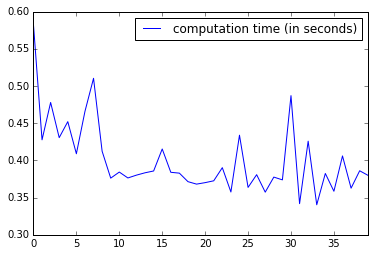

In [ ]:
pandas.DataFrame(testPageRankTimes, columns=['computation time (in seconds)']).plot();

In [ ]:
[(x[0], '%0.3f' % x[1]) for x in testPageRankResult.sortByKey().collect()]

[('A', '0.033'),
 ('B', '0.384'),
 ('C', '0.343'),
 ('D', '0.039'),
 ('E', '0.081'),
 ('F', '0.039'),
 ('G', '0.016'),
 ('H', '0.016'),
 ('I', '0.016'),
 ('J', '0.016'),
 ('K', '0.016')]

# HW 13.2: Applying PageRank to the Wikipedia hyperlinks network

> The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles:

> ```
A -> B
```

> is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

> * Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
> * Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt
> * Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt

> but has an index with more detailed data:

> ```
(article name) \t (index) \t (in degree) \t (out degree)
```

> In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

## Add Wikipedia network dangling nodes

Use ``count`` in order to materialize the RDD so that the time to load the RDDs in these stages don't affect the computation time.

In [ ]:
wikipediaOutgoingRDD = \
    sc.textFile('s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt') \
        .map(parseLine) \
        .cache()

wikipediaIncomingRDD = \
    sc.textFile('s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt') \
        .map(parseLine) \
        .cache()

print wikipediaOutgoingRDD.count()
print wikipediaIncomingRDD.count()

5781290
14216021


Since the graph is large, we'll also want to know how long it takes to fill in the missing nodes of the graph.

In [ ]:
wikipediaCompleteAdjacencyListRDD = getCompleteAdjacencyList(wikipediaOutgoingRDD, wikipediaIncomingRDD)
%time wikipediaCompleteAdjacencyListRDD.count()

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 1min


15192277

## Execute PageRank on Wikipedia network

### 10 Iterations - Execution

> Run your Spark PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

In [ ]:
%time wikipedia10PageRankTimes, wikipedia10DanglingMass, wikipedia10PageRankResult = \
    pageRank(wikipediaCompleteAdjacencyListRDD, None, 0.0, 10, True)

2016-04-27 03:27:18.039019 Materializing node count
2016-04-27 03:27:26.680220 Started page rank computation
2016-04-27 03:27:26.680349 Iteration 1 started
2016-04-27 03:29:19.819610 Iteration 2 started
2016-04-27 03:31:34.740351 Iteration 3 started
2016-04-27 03:33:48.567045 Iteration 4 started
2016-04-27 03:36:01.903928 Iteration 5 started
2016-04-27 03:38:17.045665 Iteration 6 started
2016-04-27 03:40:35.360383 Iteration 7 started
2016-04-27 03:42:53.743559 Iteration 8 started
2016-04-27 03:45:09.378989 Iteration 9 started
2016-04-27 03:47:26.280009 Iteration 10 started
2016-04-27 03:49:40.076327 Finished page rank computation
CPU times: user 488 ms, sys: 72 ms, total: 560 ms
Wall time: 22min 22s


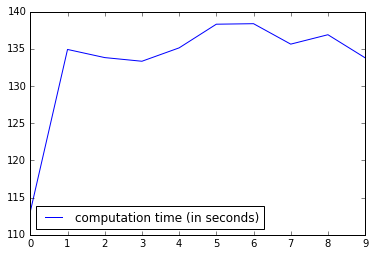

In [ ]:
pandas.DataFrame(wikipedia10PageRankTimes, columns=['computation time (in seconds)']).plot();

### 10 Iterations - Top 100

Now we take the top 100 page rank values.

In [ ]:
wikipedia10Top100PageRankValues = {
    x[0]: x[1] for x in wikipedia10PageRankResult.takeOrdered(100, lambda x: -x[1])
}

Load the indices so that we can have something that is more human-readable.

In [ ]:
wikipediaIndicesRDD = sc.textFile('s3://ucb-mids-mls-networks/wikipedia/indices.txt')

Perform a hash join of the indices with the top 100 IDs, which we can achieve in a more performant way by broadcasting the tables and generating the join via a filter followed by a map.

In [ ]:
wikipedia10Top100PageRanks = sc.broadcast(wikipedia10Top100PageRankValues)

def isTop100Index10(x):
    pageId = x.split('\t')[1]
    return pageId in wikipedia10Top100PageRanks.value

def getPageRank10(x):
    pageName, pageId, values = x.split('\t', 2)
    return pageName, wikipedia10Top100PageRanks.value[pageId]

wikipedia10Top100NamedPageRanks = wikipediaIndicesRDD \
    .filter(isTop100Index10) \
    .map(getPageRank10) \
    .takeOrdered(100, lambda x: -x[1])

pandas.set_option('display.max_rows', 100)
wikipedia10 = pandas.DataFrame(wikipedia10Top100NamedPageRanks, columns=['Page Name', 'PageRank'])
wikipedia10

,Page Name,PageRank
0,United States,0.001532
1,Animal,0.000694
2,France,0.000670
3,Germany,0.000602
4,Canada,0.000468
5,Arthropod,0.000468
6,List of sovereign states,0.000467
7,Insect,0.000462
8,United Kingdom,0.000455
9,India,0.000447


### 50 Iterations - Execution

> Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 

In [ ]:
%time wikipedia50PageRankTimes, wikipedia50DanglingMass, wikipedia50PageRankResult = \
    pageRank(wikipediaCompleteAdjacencyListRDD, wikipedia10PageRankResult, wikipedia10DanglingMass, 40, True)

2016-04-27 03:54:32.983718 Materializing node count
2016-04-27 03:54:35.601690 Started page rank computation
2016-04-27 03:54:35.601816 Iteration 1 started
2016-04-27 03:56:50.349995 Iteration 2 started
2016-04-27 03:59:04.181767 Iteration 3 started
2016-04-27 04:01:20.176071 Iteration 4 started
2016-04-27 04:03:37.391495 Iteration 5 started
2016-04-27 04:05:54.610854 Iteration 6 started
2016-04-27 04:08:11.098072 Iteration 7 started
2016-04-27 04:10:27.650343 Iteration 8 started
2016-04-27 04:12:45.086725 Iteration 9 started
2016-04-27 04:15:01.339598 Iteration 10 started
2016-04-27 04:17:18.761229 Iteration 11 started
2016-04-27 04:19:37.059989 Iteration 12 started
2016-04-27 04:21:55.917466 Iteration 13 started
2016-04-27 04:24:14.944851 Iteration 14 started
2016-04-27 04:26:33.017201 Iteration 15 started
2016-04-27 04:28:50.120648 Iteration 16 started
2016-04-27 04:31:06.779232 Iteration 17 started
2016-04-27 04:33:22.878532 Iteration 18 started
2016-04-27 04:35:38.428270 Iteration

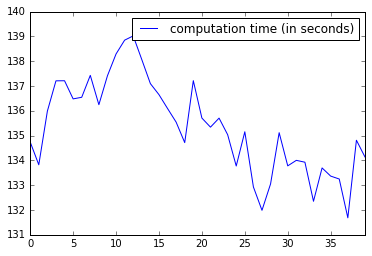

In [ ]:
pandas.DataFrame(wikipedia50PageRankTimes, columns=['computation time (in seconds)']).plot();

### 50 Iterations - Top 100

Now we take the top 100 page rank values.

In [ ]:
wikipedia50Top100PageRankValues = {
    x[0]: x[1] for x in wikipedia50PageRankResult.takeOrdered(100, lambda x: -x[1])
}

Perform a hash join of the indices with the top 100 IDs, which we can achieve in a more performant way by broadcasting the tables and generating the join via a filter followed by a map.

In [ ]:
wikipedia50Top100PageRanks = sc.broadcast(wikipedia50Top100PageRankValues)

def isTop100Index50(x):
    pageId = x.split('\t')[1]
    return pageId in wikipedia50Top100PageRanks.value

def getPageRank50(x):
    pageName, pageId, values = x.split('\t', 2)
    return pageName, wikipedia50Top100PageRanks.value[pageId]

wikipedia50Top100NamedPageRanks = wikipediaIndicesRDD \
    .filter(isTop100Index50) \
    .map(getPageRank50) \
    .takeOrdered(100, lambda x: -x[1])

pandas.set_option('display.max_rows', 100)
wikipedia50 = pandas.DataFrame(wikipedia50Top100NamedPageRanks, columns=['Page Name', 'PageRank'])
wikipedia50

,Page Name,PageRank
0,United States,0.001462
1,Animal,0.000666
2,France,0.000640
3,Germany,0.000575
4,Arthropod,0.000450
5,Canada,0.000447
6,Insect,0.000445
7,List of sovereign states,0.000444
8,United Kingdom,0.000433
9,India,0.000428


## Evaluate PageRank Results

> Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  Comment on your findings.

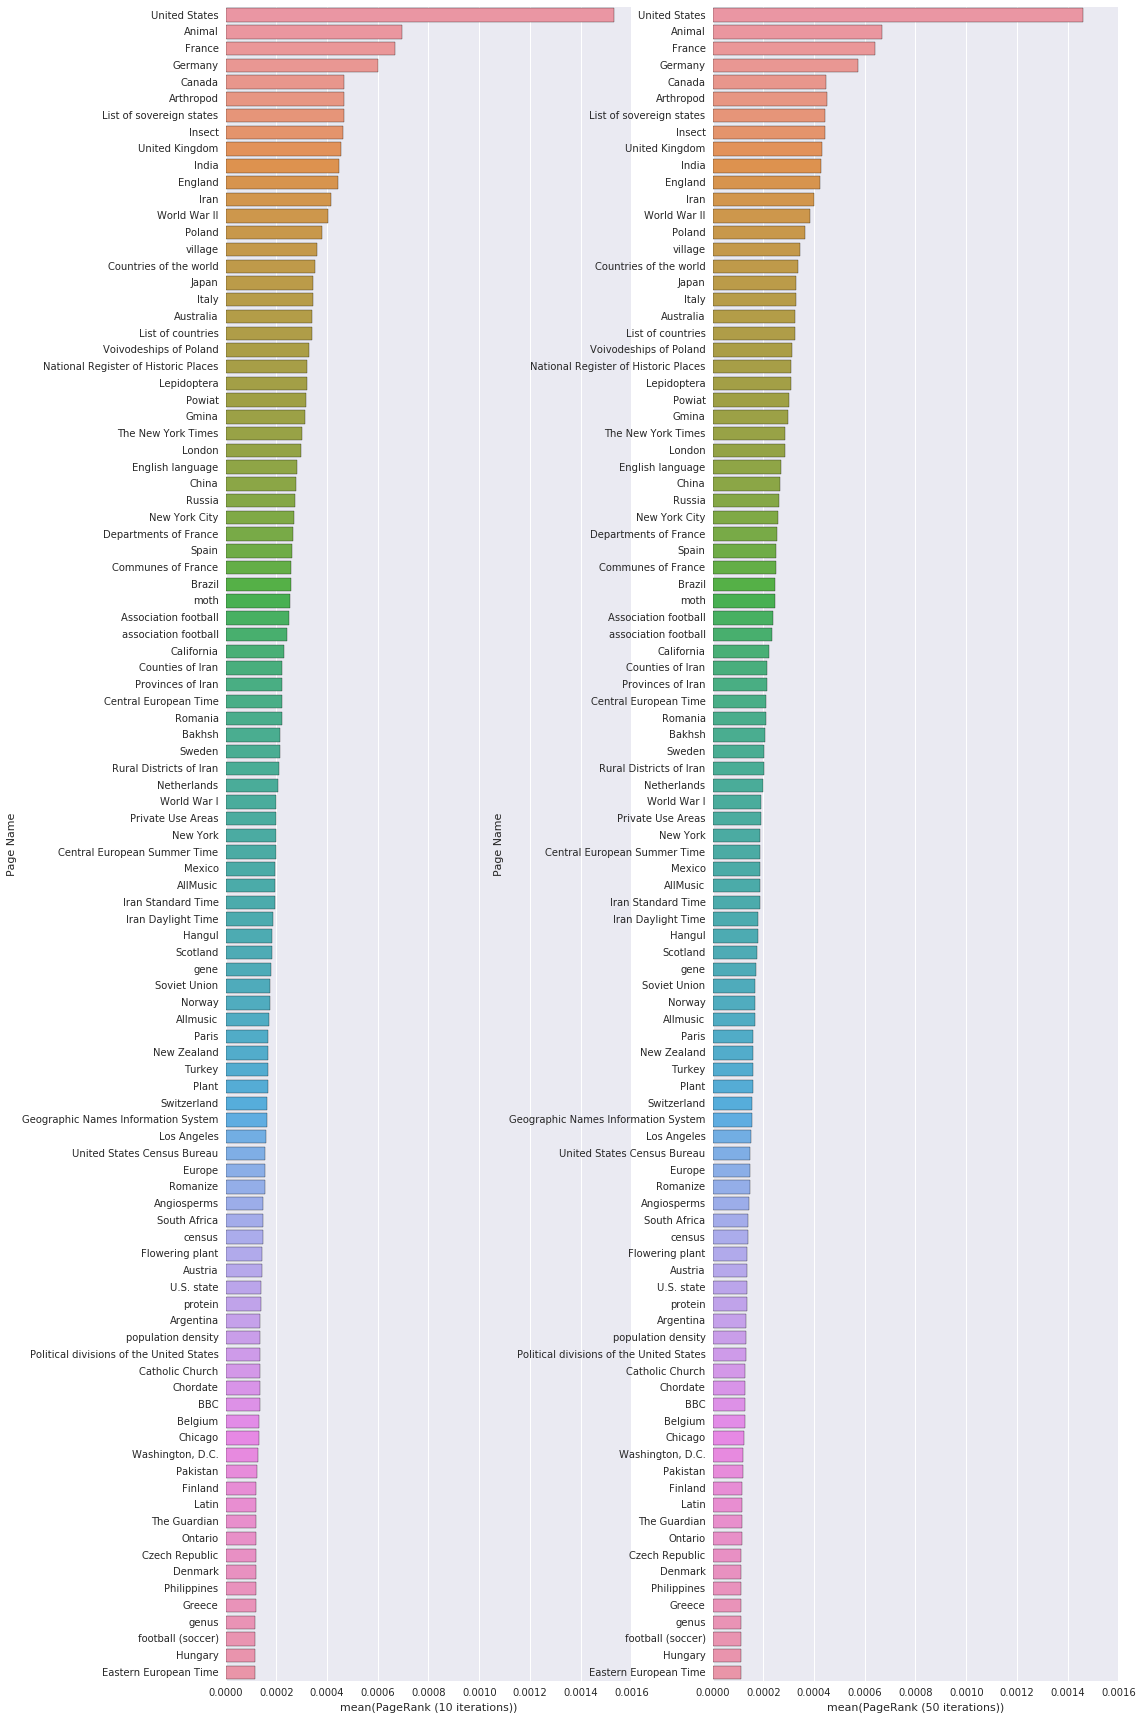

In [ ]:
wikipediaMerged = wikipedia10.merge( \
    wikipedia50, on=['Page Name'], suffixes=[' (10 iterations)', ' (50 iterations)'])

fig, axes = plt.subplots(1, 2, figsize=(16, 30))

seaborn.barplot(x='PageRank (10 iterations)', y='Page Name', data=wikipediaMerged, ax=axes[0])
seaborn.barplot(x='PageRank (50 iterations)', y='Page Name', data=wikipediaMerged, ax=axes[1])

> Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

In [ ]:
top100Nodes10 = [x[0] for x in wikipedia10Top100NamedPageRanks]
top100Nodes50 = [x[0] for x in wikipedia50Top100NamedPageRanks]

intersection = set(top100Nodes10) & set(top100Nodes50)
print 'Intersection:', len(intersection), 'nodes'

Intersection: 100 nodes


We can also check the Levenshtein distance between the two rankings to see how much the rankings themselves have changed.

In [ ]:
# Borrowed under Creative Commons
# http://hetland.org/coding/python/levenshtein.py

def levenshtein(a,b):
    "Calculates the Levenshtein distance between a and b."
    n, m = len(a), len(b)
    if n > m:
        # Make sure n <= m, to use O(min(n,m)) space
        a,b = b,a
        n,m = m,n

    current = range(n+1)
    for i in range(1,m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1,n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)

    return current[n]

print 'Levenshtein distance:', levenshtein(top100Nodes10, top100Nodes50)

Levenshtein distance: 23


This means that even though the top 100 has not changed in terms of the nodes themselves, the rankings have shifted slightly during the additional iterations. Let's identify which ones changed.

In [ ]:
[(x, y) for x, y in zip(top100Nodes10, top100Nodes50) if x != y]

[(u'Canada', u'Arthropod'),
 (u'Arthropod', u'Canada'),
 (u'List of sovereign states', u'Insect'),
 (u'Insect', u'List of sovereign states'),
 (u'Australia', u'List of countries'),
 (u'List of countries', u'Australia'),
 (u'Brazil', u'moth'),
 (u'moth', u'Brazil'),
 (u'World War I', u'Private Use Areas'),
 (u'Private Use Areas', u'World War I'),
 (u'AllMusic', u'Iran Standard Time'),
 (u'Iran Standard Time', u'AllMusic'),
 (u'Switzerland', u'Geographic Names Information System'),
 (u'Geographic Names Information System', u'Switzerland'),
 (u'United States Census Bureau', u'Romanize'),
 (u'Europe', u'United States Census Bureau'),
 (u'Romanize', u'Europe'),
 (u'U.S. state', u'protein'),
 (u'protein', u'U.S. state'),
 (u'population density', u'Political divisions of the United States'),
 (u'Political divisions of the United States', u'population density'),
 (u'Latin', u'The Guardian'),
 (u'The Guardian', u'Latin'),
 (u'Denmark', u'Philippines'),
 (u'Philippines', u'Denmark')]

Because the zip is ordered, and everything mismatched is immediately flipped, many of the top 100 are switching places back and forth as the PageRank continues to iterate, with one exception being a set of three (United States Census Bureau, Romanize, Europe) that appear to be switching places.